In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from scipy import stats
# Carica il dataset
df = pd.read_csv('final_with_emmys.csv')


In [10]:
df['new_revenue_with_CPI'], lambda_train = stats.boxcox(df['revenue_with_CPI'])

C:\Users\BOLO\miniconda3\envs\Business\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 1 center: 20.415076938593668
Cluster 2 center: 59.85012263286256
Cluster 3 center: 34.06277925407149
Cluster 4 center: 46.968742007157886


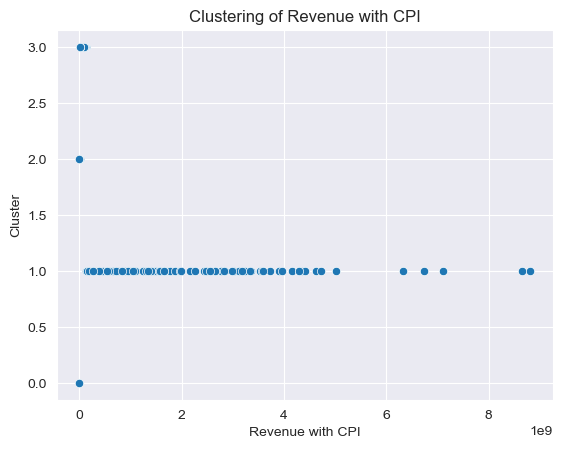

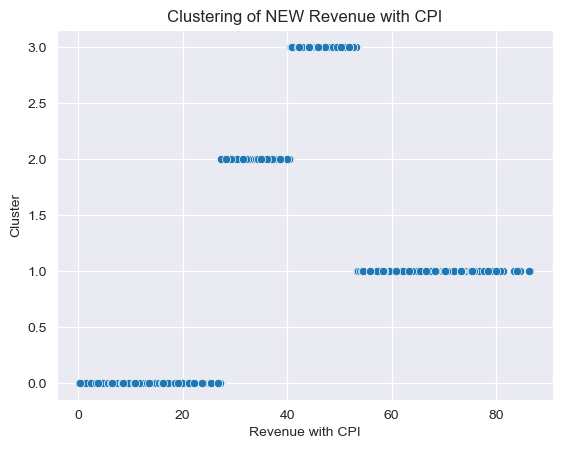

In [11]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
# Definisci il numero di cluster
num_clusters = 4

# Applica il k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['revenue_cluster'] = kmeans.fit_predict(df[['new_revenue_with_CPI']])

# Esamina i risultati del clustering
cluster_centers = kmeans.cluster_centers_
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i+1} center: {center[0]}")

# Visualizza i risultati
sns.scatterplot(data=df, x='revenue_with_CPI', y='revenue_cluster')
plt.xlabel('Revenue with CPI')
plt.ylabel('Cluster')
plt.title('Clustering of Revenue with CPI')
plt.show()

sns.scatterplot(data=df, x='new_revenue_with_CPI', y='revenue_cluster')
plt.xlabel('Revenue with CPI')
plt.ylabel('Cluster')
plt.title('Clustering of NEW Revenue with CPI')
plt.show()

df.to_csv('../test/test.csv', index=False)


Cluster 0:
Mean silhouette: 0.5634801158269578
Number of samples: 4205

Cluster 1:
Mean silhouette: 0.5373005707897643
Number of samples: 3871

Cluster 2:
Mean silhouette: 0.5201130013193064
Number of samples: 5921

Cluster 3:
Mean silhouette: 0.5302254061741989
Number of samples: 6782


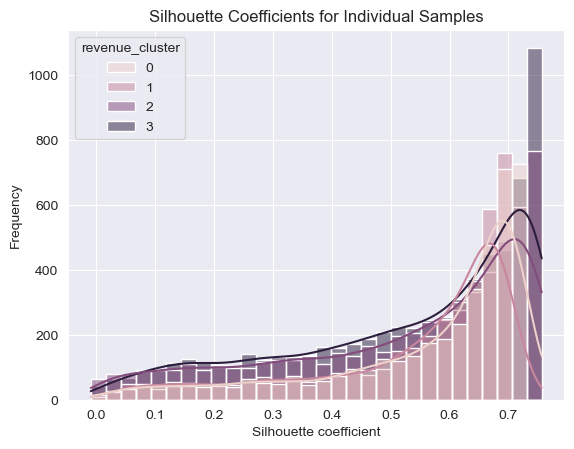

In [308]:
from sklearn.metrics import silhouette_samples

# Calcola la silhouette per ogni campione
silhouette_samples_values = silhouette_samples(df[['new_revenue_with_CPI']], df['revenue_cluster'])

# Aggiungi i valori di silhouette come colonna al DataFrame
df['silhouette'] = silhouette_samples_values

# Visualizza le silhouette dei singoli cluster
for cluster in sorted(df['revenue_cluster'].unique()):
    cluster_silhouette_values = df[df['revenue_cluster'] == cluster]['silhouette']
    print(f"Cluster {cluster}:")
    print("Mean silhouette:", cluster_silhouette_values.mean())
    print("Number of samples:", cluster_silhouette_values.shape[0])
    print("")

# Plot delle silhouette dei singoli campioni
sns.histplot(data=df, x='silhouette', hue='revenue_cluster', bins=30, kde=True)
plt.xlabel('Silhouette coefficient')
plt.ylabel('Frequency')
plt.title('Silhouette Coefficients for Individual Samples')
plt.show()

In [225]:
bins = [0, 50000000, 500000000, np.inf]  # Specifica i tuoi bin qui
labels = ['1','2', '3']  # Etichette per i bin
df['revenue_cluster'] = pd.cut(df['revenue_with_CPI'], bins=bins, labels=labels, right=False)


In [12]:
import numpy as np


# Seleziona le colonne rilevanti
columns_to_keep = [
    'genre', 'duration_df1','date_published', 'language', 'country', 'converted_budget',
    'dir_oscar_nomination', 'dir_oscar_won', 'writer_oscar_nomination',
    'BAFTA_nominees','BAFTA_awards',
    'writer_oscar_won', 'cast_oscar_nomination', 'cast_oscar_won',
    'dir_globe_nomination', 'dir_globe_won', 'production_company_df1',
    'cast_globe_nomination', 'cast_globe_won','actors_films_before','director_films_before', 'writers_films_before','revenue_cluster','dir_emmy_nom','dir_emmy_won','writer_emmy_won','writer_emmy_nom','act_emmy_nom','act_emmy_won'
]

df_selected = df[columns_to_keep].dropna()
# Visualizza le prime righe del dataset selezionato
print(df_selected.head())

# Funzione per one-hot encoding su colonne con valori multipli separati da virgole
def multi_value_one_hot(df, column):
    s = df[column].str.get_dummies(sep=', ')
    return df.join(s.add_prefix(column + '_'))

# Converti 'date_published' in formato datetime
df_selected['date_published'] = pd.to_datetime(df_selected['date_published'], errors='coerce')

# Estrai il mese dalla colonna 'date_published'
df_selected['month_published'] = df_selected['date_published'].dt.month

# Rimuovi la colonna 'date_published'
df_selected.drop(columns=['date_published'], inplace=True)

# Applica one-hot encoding alle colonne 'genre'
df_selected = multi_value_one_hot(df_selected, 'genre')

# Rimuovi le colonne originali 'genre'
df_selected.drop(columns=['genre'], inplace=True)

X = df_selected.drop('revenue_cluster', axis=1)
y = df_selected['revenue_cluster']
print(X.head())




                 genre  duration_df1 date_published language country  \
0         Crime, Drama          88.0     1913-11-24  English     USA   
1                Drama          59.0     1915-10-31  English     USA   
2  Drama, History, War          77.0     1915-11-14  English     USA   
3                Drama          50.0     1916-04-30  English     USA   
4     Adventure, Crime         300.0     1917-01-19   French  France   

   converted_budget  dir_oscar_nomination  dir_oscar_won  \
0          175700.3                     0              0   
1         3013850.0                     0              0   
2          521727.6                     0              0   
3         5598468.6                     0              0   
4        10802441.1                     0              0   

   writer_oscar_nomination  BAFTA_nominees  ...  actors_films_before  \
0                        0               0  ...                    0   
1                        0               0  ...               

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import NearestNeighbors
import numpy as np
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definisci le colonne categoriche
categorical_features = ['language', 'country', 'production_company_df1', 'month_published']
categorical_features += [col for col in X.columns if col.startswith('genre_')]

# Trova il numero di campioni della seconda classe più numerosa
class_counts = y_train.value_counts()
second_most_common_count = class_counts.nlargest(2).iloc[-1]

# Applica l'undersampling sulla classe maggioritaria riducendo al numero della seconda classe più numerosa
#rus = RandomUnderSampler(sampling_strategy={class_counts.idxmax(): second_most_common_count}, random_state=42)
#X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Applica SMOTENC solo sui dati di training dopo l'undersampling
#smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)
#X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train_resampled, y_train_resampled)
X_train_resampled, y_train_resampled = X_train, y_train
print(X_train_resampled.head())

       duration_df1 language  country  converted_budget  dir_oscar_nomination  \
10829          92.0    Other    Other         3626935.6                     0   
11234          90.0  Spanish    Other         3673271.5                     0   
19108         113.0   German  Germany        10154696.8                     0   
6869           82.0  English      USA        30486171.0                     0   
6798           86.0  English      USA       142268797.8                     0   

       dir_oscar_won  writer_oscar_nomination  BAFTA_nominees  BAFTA_awards  \
10829              0                        0               0             0   
11234              0                        0               0             0   
19108              0                        0               0             0   
6869               0                        0               0             0   
6798               0                        0               0             0   

       writer_oscar_won  ...  genre_Ho

In [14]:
# Applica one-hot encoding alla colonna 'month_published'
X_train_resampled = pd.get_dummies(X_train_resampled, columns=['month_published'], prefix='month')
X_test = pd.get_dummies(X_test, columns=['month_published'], prefix='month')

# Mantieni solo le colonne dei mesi
month_columns = [col for col in X_train_resampled.columns if col.startswith('month_')]
X_train_resampled = X_train_resampled[month_columns + [col for col in X_train_resampled.columns if not col.startswith('month_')]]

month_columns = [col for col in X_test.columns if col.startswith('month_')]
X_test = X_test[month_columns + [col for col in X_test.columns if not col.startswith('month_')]]


# Applica one-hot encoding alle colonne 'genre', 'language', 'country' e 'production_company_df1'
X_train_resampled = multi_value_one_hot(X_train_resampled, 'language')
X_train_resampled = multi_value_one_hot(X_train_resampled, 'country')
X_train_resampled = multi_value_one_hot(X_train_resampled, 'production_company_df1')


X_test = multi_value_one_hot(X_test, 'language')
X_test = multi_value_one_hot(X_test, 'country')
X_test = multi_value_one_hot(X_test, 'production_company_df1')

# Rimuovi le colonne originali 'genre', 'language', 'country' e 'production_company_df1'
X_train_resampled.drop(columns=['language', 'country', 'production_company_df1','country_Other','language_Other','production_company_df1_Other'], inplace=True)
X_test.drop(columns=['language', 'country', 'production_company_df1','country_Other','language_Other','production_company_df1_Other'], inplace=True)

# Rimuovi righe con NaN nella colonna 'converted_budget'
#df_selected = df_selected.dropna(subset=['converted_budget'])

# Normalizzazione delle variabili numeriche
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_columns = ['duration_df1', 'converted_budget', 
                     'dir_oscar_nomination', 'dir_oscar_won', 
                     'writer_oscar_nomination', 'writer_oscar_won', 
                     'cast_oscar_nomination', 'cast_oscar_won', 
                     'dir_globe_nomination', 'dir_globe_won', 
                     'cast_globe_nomination', 'cast_globe_won',
                     'BAFTA_nominees','BAFTA_awards',
                     'actors_films_before', 'director_films_before', 'writers_films_before',
                     'dir_emmy_nom','dir_emmy_won','writer_emmy_won','writer_emmy_nom','act_emmy_nom','act_emmy_won']

lambdas_train = {}
lambdas_test = {}
for col in numerical_columns:
    print(col)
    # La trasformazione di Box-Cox richiede valori positivi, aggiungi 1 se ci sono zeri o negativi
    X_train_resampled[col], lambdas_train[col] = stats.boxcox(X_train_resampled[col] + 1)
    X_test[col], lambdas_test[col] = stats.boxcox(X_test[col] + 1)
 
scaler = StandardScaler()

# Adatta lo scaler solo al training set e poi trasforma sia il training set che il test set
X_train_resampled[numerical_columns] = scaler.fit_transform(X_train_resampled[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])


X_train_resampled, X_test = X_train_resampled.align(X_test, join='outer', axis=1, fill_value=0)

#X_train_resampled = X_train_resampled[selected_features_mi.to_list()]
#X_test = X_test[selected_features_mi.to_list()]

# Verifichiamo il risultato
print(X_train_resampled.head())

duration_df1
converted_budget
dir_oscar_nomination
dir_oscar_won
writer_oscar_nomination
writer_oscar_won
cast_oscar_nomination
cast_oscar_won
dir_globe_nomination
dir_globe_won
cast_globe_nomination
cast_globe_won
BAFTA_nominees
BAFTA_awards
actors_films_before
director_films_before
writers_films_before
dir_emmy_nom
dir_emmy_won
writer_emmy_won
writer_emmy_nom
act_emmy_nom
act_emmy_won
       month_1  month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
10829    False    False    False    False     True    False    False    False   
11234    False    False    False    False    False    False    False    False   
19108    False    False    False    False    False     True    False    False   
6869     False    False    False    False    False    False    False    False   
6798     False    False    False    False    False    False     True    False   

       month_9  month_10  ...  production_company_df1_Lionsgate  \
10829    False     False  ...                           

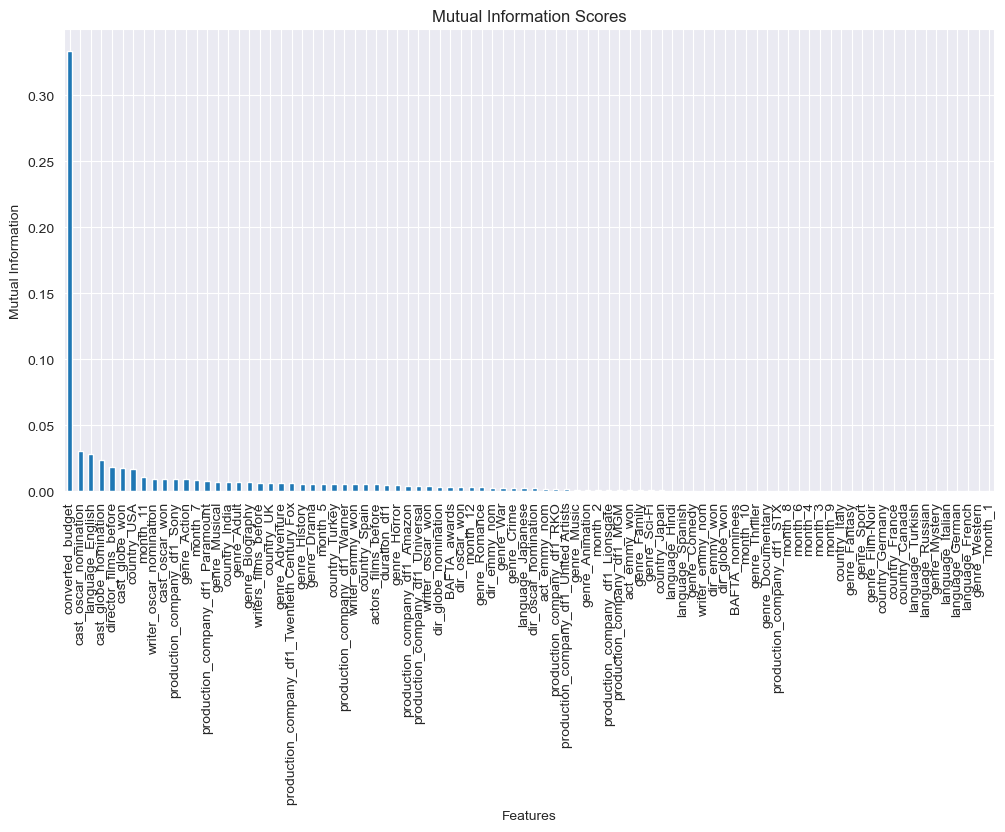

Selected features based on Mutual Information:
Index(['converted_budget', 'cast_oscar_nomination', 'language_English',
       'cast_globe_nomination', 'director_films_before', 'cast_globe_won',
       'country_USA', 'month_11', 'writer_oscar_nomination', 'cast_oscar_won',
       'production_company_df1_Sony', 'genre_Action', 'month_7',
       'production_company_df1_Paramount', 'genre_Musical', 'country_India',
       'genre_Adult', 'genre_Biography', 'writers_films_before', 'country_UK',
       'genre_Adventure', 'production_company_df1_Twentieth Century Fox',
       'genre_History', 'genre_Drama', 'month_5', 'country_Turkey',
       'production_company_df1_Warner', 'writer_emmy_won', 'country_Spain',
       'actors_films_before', 'duration_df1', 'genre_Horror',
       'production_company_df1_Amazon', 'production_company_df1_Universal',
       'writer_oscar_won', 'dir_globe_nomination', 'BAFTA_awards',
       'dir_oscar_won', 'month_12', 'genre_Romance', 'dir_emmy_nom',
       'genre_

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

# Applica one-hot encoding alla colonna 'month_published'
X_train = pd.get_dummies(X_train, columns=['month_published'], prefix='month')

# Mantieni solo le colonne dei mesi
month_columns = [col for col in X_train.columns if col.startswith('month_')]
X_train = X_train[month_columns + [col for col in X_train.columns if not col.startswith('month_')]]

# Applica one-hot encoding alle colonne 'genre', 'language', 'country' e 'production_company_df1'
X_train = multi_value_one_hot(X_train, 'language')
X_train = multi_value_one_hot(X_train, 'country')
X_train = multi_value_one_hot(X_train, 'production_company_df1')

# Rimuovi le colonne originali 'genre', 'language', 'country' e 'production_company_df1'
X_train.drop(columns=['language', 'country', 'production_company_df1','country_Other','language_Other','production_company_df1_Other'], inplace=True)

# Rimuovi righe con NaN nella colonna 'converted_budget'
X_train = X_train.dropna(subset=['converted_budget'])

lambdas = {}
for col in numerical_columns:
    # La trasformazione di Box-Cox richiede valori positivi, aggiungi 1 se ci sono zeri o negativi
    X_train[col], lambdas[col] = stats.boxcox(X_train[col] + 1)
scaler = StandardScaler()

# Adatta lo scaler solo al training set e poi trasforma sia il training set che il test set
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])

# Calcola la mutual information tra ogni feature e la variabile target
mi = mutual_info_classif(X_train, y_train, discrete_features='auto', random_state=42)

# Crea un DataFrame per visualizzare i punteggi
mi_scores = pd.Series(mi, index=X_train.columns).sort_values(ascending=False)

# Traccia un grafico dei punteggi di mutual information
plt.figure(figsize=(12, 6))
mi_scores.plot(kind='bar')
plt.title('Mutual Information Scores')
plt.ylabel('Mutual Information')
plt.xlabel('Features')
plt.show()

# Identifica il punto di taglio (puoi osservare il grafico per trovare un calo significativo)
threshold = 0.001  # Esempio di soglia, puoi modificare in base al grafico

# Seleziona le feature con punteggi di mutual information sopra la soglia
selected_features_mi = mi_scores[mi_scores > threshold].index
print("Selected features based on Mutual Information:")
print(selected_features_mi)


X_train_resampled = X_train_resampled[selected_features_mi.to_list()]
X_test = X_test[selected_features_mi.to_list()]

# Verifica del risultato
print(X_train_resampled.head())

In [16]:

# Addestra il modello Random Forest
rf_classifier = RandomForestClassifier(n_jobs=10, n_estimators=500, max_features=10)
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Fai previsioni sui dati di test
y_pred_test = rf_classifier.predict(X_test)

# Fai previsioni sui dati di train
y_pred_train = rf_classifier.predict(X_train_resampled)

# Calcola le metriche di valutazione per il test set
accuracy_test = accuracy_score(y_test, y_pred_test)
report_test = classification_report(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

# Calcola le metriche di valutazione per il train set
accuracy_train = accuracy_score(y_train_resampled, y_pred_train)
report_train = classification_report(y_train_resampled, y_pred_train)
conf_matrix_train = confusion_matrix(y_train_resampled, y_pred_train)

print(f'Test Set - Accuracy: {accuracy_test}')
print(f'Test Set - Classification Report:\n{report_test}')
print(f'Test Set - Confusion Matrix:\n{conf_matrix_test}')

print(f'\nTrain Set - Accuracy: {accuracy_train}')
print(f'Train Set - Classification Report:\n{report_train}')
print(f'Train Set - Confusion Matrix:\n{conf_matrix_train}')




Test Set - Accuracy: 0.4754257907542579
Test Set - Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.18      0.27       839
           1       0.52      0.68      0.59       750
           2       0.42      0.49      0.45      1141
           3       0.49      0.53      0.51      1380

    accuracy                           0.48      4110
   macro avg       0.48      0.47      0.45      4110
weighted avg       0.48      0.48      0.46      4110

Test Set - Confusion Matrix:
[[154  19 501 165]
 [  5 511  25 209]
 [108  73 557 403]
 [ 38 382 228 732]]

Train Set - Accuracy: 1.0
Train Set - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3268
           1       1.00      1.00      1.00      3110
           2       1.00      1.00      1.00      4700
           3       1.00      1.00      1.00      5361

    accuracy                           1.00     164

In [303]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

adaboost_classifier = AdaBoostClassifier(random_state=42)

# Allena il modello
adaboost_classifier.fit(X_train_resampled, y_train_resampled)

# Fai previsioni sui dati di test
y_pred_test = adaboost_classifier.predict(X_test)

y_pred_train = adaboost_classifier.predict(X_train_resampled)

# Calcola le metriche di valutazione per il test set
accuracy_test = accuracy_score(y_test, y_pred_test)
report_test = classification_report(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)


# Calcola le metriche di valutazione per il test set
accuracy_train = accuracy_score(y_train_resampled, y_pred_train)
report_train = classification_report(y_train_resampled, y_pred_train)
conf_matrix_train = confusion_matrix(y_train_resampled, y_pred_train)

print(f'Test Set - Accuracy: {accuracy_test}')
print(f'Test Set - Classification Report:\n{report_test}')
print(f'Test Set - Confusion Matrix:\n{conf_matrix_test}')

print(f'\nTrain Set - Accuracy: {accuracy_train}')
print(f'Train Set - Classification Report:\n{report_train}')
print(f'Train Set - Confusion Matrix:\n{conf_matrix_train}')



Test Set - Accuracy: 0.5002433090024331
Test Set - Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.34      0.40       821
           1       0.63      0.54      0.58       758
           2       0.44      0.50      0.46      1151
           3       0.51      0.58      0.54      1380

    accuracy                           0.50      4110
   macro avg       0.51      0.49      0.50      4110
weighted avg       0.50      0.50      0.50      4110

Test Set - Confusion Matrix:
[[282  10 409 120]
 [ 13 407  36 302]
 [213  24 572 342]
 [ 80 208 297 795]]

Train Set - Accuracy: 0.5231143552311436
Train Set - Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.37      0.42      3286
           1       0.67      0.58      0.62      3102
           2       0.46      0.51      0.48      4691
           3       0.53      0.60      0.56      5361

    accuracy                        

In [304]:
from sklearn.ensemble import GradientBoostingClassifier

# Definizione del classificatore Gradient Boosting
gradient_boosting_classifier = GradientBoostingClassifier(random_state=42)

# Allena il modello
gradient_boosting_classifier.fit(X_train_resampled, y_train_resampled)

# Fai previsioni sui dati di test
y_pred_test = gradient_boosting_classifier.predict(X_test)
y_pred_train = gradient_boosting_classifier.predict(X_train_resampled)

# Calcola le metriche di valutazione per il test set
accuracy_test = accuracy_score(y_test, y_pred_test)
report_test = classification_report(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

# Calcola le metriche di valutazione per il train set
accuracy_train = accuracy_score(y_train_resampled, y_pred_train)
report_train = classification_report(y_train_resampled, y_pred_train)
conf_matrix_train = confusion_matrix(y_train_resampled, y_pred_train)

print(f'Test Set - Accuracy: {accuracy_test}')
print(f'Test Set - Classification Report:\n{report_test}')
print(f'Test Set - Confusion Matrix:\n{conf_matrix_test}')

print(f'\nTrain Set - Accuracy: {accuracy_train}')
print(f'Train Set - Classification Report:\n{report_train}')
print(f'Train Set - Confusion Matrix:\n{conf_matrix_train}')


Test Set - Accuracy: 0.5347931873479319
Test Set - Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.44      0.48       821
           1       0.70      0.51      0.59       758
           2       0.47      0.48      0.47      1151
           3       0.53      0.65      0.58      1380

    accuracy                           0.53      4110
   macro avg       0.56      0.52      0.53      4110
weighted avg       0.54      0.53      0.53      4110

Test Set - Confusion Matrix:
[[361  11 330 119]
 [  8 390  32 328]
 [228  20 547 356]
 [ 79 140 261 900]]

Train Set - Accuracy: 0.5729318734793187
Train Set - Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.46      0.52      3286
           1       0.74      0.58      0.65      3102
           2       0.52      0.54      0.53      4691
           3       0.55      0.67      0.60      5361

    accuracy                        

In [228]:
from sklearn.preprocessing import StandardScaler

def preprocess_data(X_train, X_test, categorical_features):
    # Scale numerical features
    scaler = StandardScaler()
    numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns
    X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
    X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

    # One-hot encode categorical features
    X_train = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
    X_test = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)

    return X_train, X_test

from sklearn.feature_selection import mutual_info_classif

def select_features(X_train, y_train, threshold=0.001):
    mi = mutual_info_classif(X_train, y_train, discrete_features='auto', random_state=42)
    selected_features = X_train.columns[mi > threshold]
    return X_train[selected_features], selected_features

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC

def perform_sampling(X_train_fold, y_train_fold, categorical_features):
    
    class_counts = y_train_fold.value_counts()
    second_most_common_count = class_counts.nlargest(2).iloc[-1]

    # Applica l'undersampling sulla classe maggioritaria riducendo al numero della seconda classe più numerosa
    rus = RandomUnderSampler(sampling_strategy={class_counts.idxmax(): second_most_common_count}, random_state=42)
    X_fold_resampled, y_fold_resampled = rus.fit_resample(X_train_fold, y_train_fold)

    # Applica SMOTENC solo sui dati di training dopo l'undersampling
    smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)
    X_fold_resampled, y_fold_resampled = smote_nc.fit_resample(X_fold_resampled, y_fold_resampled)

    return X_fold_resampled, y_fold_resampled


In [318]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# Normalizzazione delle variabili numeriche
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif


# Definisci la strategia di cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True)

# Initialize lists to save the evaluation metrics for each fold
train_accuracies = []
train_precisions = []
train_recalls = []
train_f1_scores = []
train_roc_auc_scores = []

test_accuracies = []
test_precisions = []
test_recalls = []
test_f1_scores = []
test_roc_auc_scores = []


# Definisci le colonne categoriche
categorical_features = ['language', 'country', 'production_company_df1', 'month_published']
categorical_features += [col for col in X.columns if col.startswith('genre_')]

rf_classifier = RandomForestClassifier(n_jobs=10, n_estimators=100, max_features=4)
gradient_boosting_classifier = GradientBoostingClassifier(random_state=42)

# Loop attraverso i fold
for train_index, test_index in cv.split(X, y):
    # Dividi i dati in training e test set per il fold corrente
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    

    # Sampling
    X_fold_resampled, y_fold_resampled = perform_sampling(X_train_fold, y_train_fold, categorical_features)

    X_fold_resampled = pd.get_dummies(X_fold_resampled, columns=['month_published'], prefix='month')
    X_test_fold = pd.get_dummies(X_test_fold, columns=['month_published'], prefix='month')

    # Mantieni solo le colonne dei mesi
    month_columns = [col for col in X_fold_resampled.columns if col.startswith('month_')]
    X_fold_resampled = X_fold_resampled[month_columns + [col for col in X_fold_resampled.columns if not col.startswith('month_')]]

    month_columns = [col for col in X_test_fold.columns if col.startswith('month_')]
    X_test_fold = X_test_fold[month_columns + [col for col in X_test_fold.columns if not col.startswith('month_')]]


    # Applica one-hot encoding alle colonne 'genre', 'language', 'country' e 'production_company_df1'
    X_fold_resampled = multi_value_one_hot(X_fold_resampled, 'language')
    X_fold_resampled = multi_value_one_hot(X_fold_resampled, 'country')
    X_fold_resampled = multi_value_one_hot(X_fold_resampled, 'production_company_df1')


    X_test_fold = multi_value_one_hot(X_test_fold, 'language')
    X_test_fold = multi_value_one_hot(X_test_fold, 'country')
    X_test_fold = multi_value_one_hot(X_test_fold, 'production_company_df1')

    # Rimuovi le colonne originali 'genre', 'language', 'country' e 'production_company_df1'
    X_fold_resampled.drop(columns=['language', 'country', 'production_company_df1'], inplace=True)
    X_test_fold.drop(columns=['language', 'country', 'production_company_df1'], inplace=True)

    scaler = StandardScaler()
    numerical_columns = ['duration_df1', 'converted_budget', 
                     'dir_oscar_nomination', 'dir_oscar_won', 
                     'writer_oscar_nomination', 'writer_oscar_won', 
                     'cast_oscar_nomination', 'cast_oscar_won', 
                     'dir_globe_nomination', 'dir_globe_won', 
                     'cast_globe_nomination', 'cast_globe_won',
                     'BAFTA_nominees','BAFTA_awards',
                     'actors_films_before', 'director_films_before', 'writers_films_before']
    
    X_fold_resampled[numerical_columns] = scaler.fit_transform(X_fold_resampled[numerical_columns])
    X_test_fold[numerical_columns] = scaler.fit_transform(X_test_fold[numerical_columns])

    X_fold_resampled, X_test_fold = X_fold_resampled.align(X_test_fold, join='outer', axis=1, fill_value=0)


    # Applica one-hot encoding alla colonna 'month_published'
    X_train_fold = pd.get_dummies(X_train_fold, columns=['month_published'], prefix='month')

    # Mantieni solo le colonne dei mesi
    month_columns = [col for col in X_train_fold.columns if col.startswith('month_')]
    X_train_fold = X_train_fold[month_columns + [col for col in X_train_fold.columns if not col.startswith('month_')]]

    # Applica one-hot encoding alle colonne 'genre', 'language', 'country' e 'production_company_df1'
    X_train_fold = multi_value_one_hot(X_train_fold, 'language')
    X_train_fold = multi_value_one_hot(X_train_fold, 'country')
    X_train_fold = multi_value_one_hot(X_train_fold, 'production_company_df1')

    # Rimuovi le colonne originali 'genre', 'language', 'country' e 'production_company_df1'
    X_train_fold.drop(columns=['language', 'country', 'production_company_df1'], inplace=True)

    # Rimuovi righe con NaN nella colonna 'converted_budget'
    X_train_fold = X_train_fold.dropna(subset=['converted_budget'])


    # Calcola la mutual information tra ogni feature e la variabile target
    mi = mutual_info_classif(X_train_fold, y_train_fold, discrete_features='auto', random_state=42)

    # Crea un DataFrame per visualizzare i punteggi
    mi_scores = pd.Series(mi, index=X_train_fold.columns).sort_values(ascending=False)


    # Identifica il punto di taglio (puoi osservare il grafico per trovare un calo significativo)
    threshold = 0.001  # Esempio di soglia, puoi modificare in base al grafico

    # Seleziona le feature con punteggi di mutual information sopra la soglia
    selected_features_mi = mi_scores[mi_scores > threshold].index

    X_fold_resampled = X_fold_resampled[selected_features_mi.to_list()]
    X_test_fold = X_test_fold[selected_features_mi.to_list()]

    # Addestra il modello sui dati di training preprocessati e campionati
    rf_classifier.fit(X_fold_resampled, y_fold_resampled)

    

    y_pred_test = rf_classifier.predict(X_test_fold)

    y_pred_train = rf_classifier.predict(X_fold_resampled)

    test_accuracies.append(accuracy_score(y_test_fold, y_pred_test))
    test_precisions.append(precision_score(y_test_fold, y_pred_test, average='weighted'))
    test_recalls.append(recall_score(y_test_fold, y_pred_test, average='weighted'))
    test_f1_scores.append(f1_score(y_test_fold, y_pred_test, average='weighted'))
    test_roc_auc_scores.append(roc_auc_score(y_test_fold, rf_classifier.predict_proba(X_test_fold), multi_class='ovr'))

    # Calculate the evaluation metrics for the training set
    train_accuracies.append(accuracy_score(y_fold_resampled, y_pred_train))
    train_precisions.append(precision_score(y_fold_resampled, y_pred_train, average='weighted'))
    train_recalls.append(recall_score(y_fold_resampled, y_pred_train, average='weighted'))
    train_f1_scores.append(f1_score(y_fold_resampled, y_pred_train, average='weighted'))
    train_roc_auc_scores.append(roc_auc_score(y_fold_resampled, rf_classifier.predict_proba(X_fold_resampled), multi_class='ovr'))

    # Print metrics for the current fold
    print(f"Fold {len(test_accuracies)}")
    print(f"Train accuracy: {train_accuracies[-1]}")
    print(f"Train precision: {train_precisions[-1]}")
    print(f"Train recall: {train_recalls[-1]}")
    print(f"Train F1-score: {train_f1_scores[-1]}")
    print(f"Train ROC AUC score: {train_roc_auc_scores[-1]}")
    print(f"Test accuracy: {test_accuracies[-1]}")
    print(f"Test precision: {test_precisions[-1]}")
    print(f"Test recall: {test_recalls[-1]}")
    print(f"Test F1-score: {test_f1_scores[-1]}")
    print(f"Test ROC AUC score: {test_roc_auc_scores[-1]}")
    print()

# Calculate the mean of the evaluation metrics across all folds for the test set
mean_test_accuracy = sum(test_accuracies) / len(test_accuracies)
mean_test_precision = sum(test_precisions) / len(test_precisions)
mean_test_recall = sum(test_recalls) / len(test_recalls)
mean_test_f1_score = sum(test_f1_scores) / len(test_f1_scores)
mean_test_roc_auc_score = sum(test_roc_auc_scores) / len(test_roc_auc_scores)

# Calculate the mean of the evaluation metrics across all folds for the training set
mean_train_accuracy = sum(train_accuracies) / len(train_accuracies)
mean_train_precision = sum(train_precisions) / len(train_precisions)
mean_train_recall = sum(train_recalls) / len(train_recalls)
mean_train_f1_score = sum(train_f1_scores) / len(train_f1_scores)
mean_train_roc_auc_score = sum(train_roc_auc_scores) / len(train_roc_auc_scores)

# Print the mean evaluation metrics
print("Mean training accuracy:", mean_train_accuracy)
print("Mean training precision:", mean_train_precision)
print("Mean training recall:", mean_train_recall)
print("Mean training F1-score:", mean_train_f1_score)
print("Mean training ROC AUC score:", mean_train_roc_auc_score)

print("Mean test accuracy:", mean_test_accuracy)
print("Mean test precision:", mean_test_precision)
print("Mean test recall:", mean_test_recall)
print("Mean test F1-score:", mean_test_f1_score)
print("Mean test ROC AUC score:", mean_test_roc_auc_score)

Fold 1
Train accuracy: 1.0
Train precision: 1.0
Train recall: 1.0
Train F1-score: 1.0
Train ROC AUC score: 1.0
Test accuracy: 0.5046228710462287
Test precision: 0.5056193930922812
Test recall: 0.5046228710462287
Test F1-score: 0.49666182195306224
Test ROC AUC score: 0.7846843716973162
Fold 2
Train accuracy: 1.0
Train precision: 1.0
Train recall: 1.0
Train F1-score: 1.0
Train ROC AUC score: 1.0
Test accuracy: 0.48126520681265206
Test precision: 0.47912984578397705
Test recall: 0.48126520681265206
Test F1-score: 0.47475523025380717
Test ROC AUC score: 0.7633587921093454
Fold 3
Train accuracy: 1.0
Train precision: 1.0
Train recall: 1.0
Train F1-score: 1.0
Train ROC AUC score: 1.0
Test accuracy: 0.4895377128953771
Test precision: 0.49084043354152723
Test recall: 0.4895377128953771
Test F1-score: 0.4811059782138425
Test ROC AUC score: 0.7692099760526037
Fold 4
Train accuracy: 1.0
Train precision: 1.0
Train recall: 1.0
Train F1-score: 1.0
Train ROC AUC score: 1.0
Test accuracy: 0.48223844282